In [1]:
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), 'examples'))
	print(os.getcwd())
except:
	pass


d:\research\repos\lib-attribution\examples


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["KERAS_BACKEND"]="tensorflow"


In [3]:
import sys
sys.path.append('..')



In [4]:
import warnings
warnings.simplefilter("ignore")



In [5]:
import numpy as np

import keras
import keras.backend as K



Using TensorFlow backend.


In [6]:
K.set_image_data_format('channels_last')



In [7]:
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

# helper to simplify displaying multiple images
def imshow(image, width=64, height=64, size=None):
    
    im = np.array(image, copy=True)
    if image.min() < 0:
        im -= im.min()
    im /= im.max()
    im = (im*255.).astype(np.uint8)
    if np.ndim(im) == 3:
        im = np.expand_dims(im, 0)
 
    n = len(im)
    s = int(np.ceil(np.sqrt(n)))
    
    if size is None:
        size = 2*s
    
    fig, axs = plt.subplots(s, s)
    fig.set_size_inches(size,size)
    if s == 1:
        axs.imshow(im[0])
    else:
        cnt = 0
        for i in range(s):
            for j in range(s):
                if cnt < n:
                    axs[i,j].imshow(im[cnt, :,:,:])
                axs[i,j].axis('off')
                axs[i,j].set_aspect('equal')
                cnt += 1
        fig.subplots_adjust(wspace=0, hspace=0.)

    plt.show()


In [8]:
from sklearn.datasets import fetch_olivetti_faces, fetch_lfw_people

# Use only classes that have at least 100 images
# There are five such classes in LFW
lfw_slice = (slice(68, 196, None), slice(61, 190, None))
faces_data = fetch_lfw_people(min_faces_per_person=100, color=True, slice_=lfw_slice)
images = faces_data.images
n_classes = faces_data.target.max()+1
x, y = faces_data.data, keras.utils.to_categorical(faces_data.target, n_classes)
images /= 255.0

# Use 3/4 for training, the rest for testing
N_tr = int(len(x)*0.75)
N_te = len(x) - N_tr
x_tr, y_tr = x[:N_tr], y[:N_tr]
x_te, y_te = x[N_tr:], y[N_tr:]
im_tr, im_te = images[:N_tr], images[N_tr:]



C:\Users\mattf\Miniconda3\envs\dl-tf\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


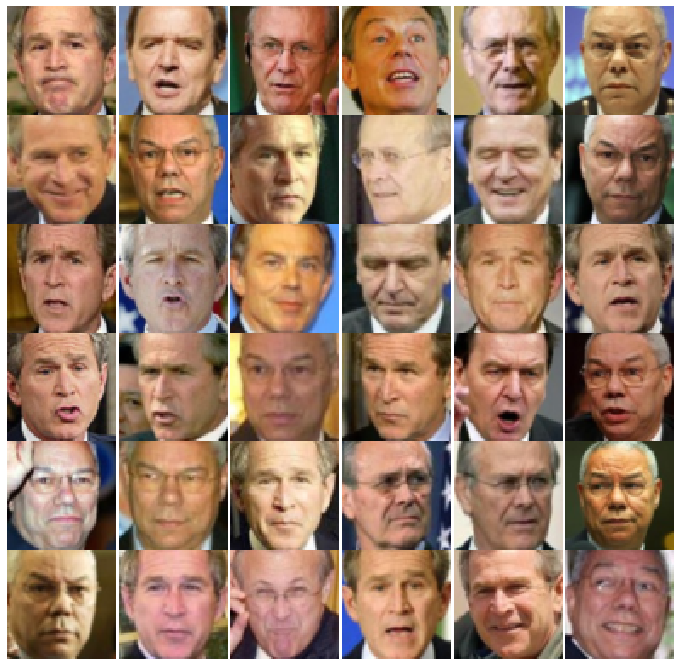

In [9]:
imshow(images[:36])


 We'll use a small convnet to demonstrate, but with enough depth for interesting results

In [10]:
inp = keras.layers.Input(shape=im_tr[0].shape)
out = keras.layers.Conv2D(128, (3,3), activation='relu')(inp)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(64, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(32, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Conv2D(16, (3,3), activation='relu')(out)
out = keras.layers.MaxPooling2D(pool_size=(2,2))(out)
out = keras.layers.Flatten()(out)
out = keras.layers.Dense(16, activation='relu')(out)
out = keras.layers.Dense(y[0].shape[0], activation='softmax')(out)
model = keras.Model(inp, out)
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_

 The model was originally trained with:

 `model.fit(im_tr, y_tr, batch_size=32, epochs=40, validation_data=(im_te, y_te))`

In [11]:
model.load_weights('weights/lfw-small-tf.h5')


In [12]:
print('accuracy:')
print('train={:.2}'.format(model.evaluate(im_tr, y_tr, verbose=False)[1]))
print('test={:.2}'.format(model.evaluate(im_te, y_te, verbose=False)[1]))


accuracy:
train=1.0
test=0.81


In [13]:
from attribution.model_utils import replace_softmax_with_logits
model = replace_softmax_with_logits(model)


 # Finding invariants

 Now let's find some invariants of the model. The main class for doing so is ``ActivationInvariants``.

In [15]:
from attribution.ActivationInvariants import ActivationInvariants
from attribution.InfluenceInvariants import InfluenceInvariants

actinv = ActivationInvariants(model, layers=[9], agg_fn=None).compile()
infinv = InfluenceInvariants(model, layer=9, agg_fn=None).compile()


Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [16]:
invs_act = actinv.get_invariants(im_tr)


In [17]:
invs_inf = infinv.get_invariants(im_tr)


 # Results: comparing activation to influence invariants

In [18]:
supports_act = [inv.support for inv in invs_act]
supports_inf = [inv.support for inv in invs_inf]
print('# invariants: {} (act), {} (inf)\n'.format(len(invs_act), len(invs_inf)))
print('avg support: {:.2} (act), {:.2} (inf)'.format(np.array(supports_act).mean(), np.array(supports_inf).mean()))


# invariants: 132 (act), 7 (inf)

avg support: 0.0095 (act), 0.71 (inf)


 ## More detail: influence
 We see that there are just seven influence invariants that cover the entire training set with perfect precision

In [19]:
for inv in invs_inf:
    print(inv)


(flatten_1[42] > 0)
	--> Q = 2
support=1.0, precision=1.0
(flatten_1[42] <= 0 &
 flatten_1[62] > 0 &
 flatten_1[63] > 0 &
 flatten_1[41] > 0)
	--> Q = 1
support=0.0106, precision=1.0
(flatten_1[42] <= 0 &
 flatten_1[62] > 0 &
 flatten_1[63] > 0 &
 flatten_1[41] <= 0)
	--> Q = 0
support=1.0, precision=1.0
(flatten_1[42] <= 0 &
 flatten_1[62] > 0 &
 flatten_1[63] <= 0 &
 flatten_1[47] > 0)
	--> Q = 3
support=0.0123, precision=1.0
(flatten_1[42] <= 0 &
 flatten_1[62] > 0 &
 flatten_1[63] <= 0 &
 flatten_1[47] <= 0)
	--> Q = 1
support=0.989, precision=1.0
(flatten_1[42] <= 0 &
 flatten_1[62] <= 0 &
 flatten_1[14] > 0)
	--> Q = 3
support=0.988, precision=1.0
(flatten_1[42] <= 0 &
 flatten_1[62] <= 0 &
 flatten_1[14] <= 0)
	--> Q = 4
support=1.0, precision=1.0


 ## More detail: activation
 There are 132 activation invariants to cover the training set

In [20]:
for inv in invs_act[:10]:
    print(inv)


(flatten_1[56] != 0 &
 flatten_1[57] != 0 &
 flatten_1[9] != 0 &
 flatten_1[37] != 0 &
 flatten_1[25] != 0 &
 flatten_1[41] != 0 &
 flatten_1[32] != 0 &
 flatten_1[5] != 0)
	--> Q = 1
support=0.0106, precision=1.0
(flatten_1[56] != 0 &
 flatten_1[57] != 0 &
 flatten_1[9] != 0 &
 flatten_1[37] != 0 &
 flatten_1[25] != 0 &
 flatten_1[41] != 0 &
 flatten_1[32] != 0 &
 flatten_1[5] = 0)
	--> Q = 0
support=0.00543, precision=1.0
(flatten_1[56] != 0 &
 flatten_1[57] != 0 &
 flatten_1[9] != 0 &
 flatten_1[37] != 0 &
 flatten_1[25] != 0 &
 flatten_1[41] = 0)
	--> Q = 0
support=0.00543, precision=1.0
(flatten_1[56] != 0 &
 flatten_1[57] != 0 &
 flatten_1[9] != 0 &
 flatten_1[37] != 0 &
 flatten_1[25] = 0)
	--> Q = 4
support=0.0404, precision=1.0
(flatten_1[56] != 0 &
 flatten_1[57] != 0 &
 flatten_1[9] != 0 &
 flatten_1[37] = 0 &
 flatten_1[0] != 0 &
 flatten_1[5] != 0 &
 flatten_1[25] != 0)
	--> Q = 2
support=0.0176, precision=1.0
(flatten_1[56] != 0 &
 flatten_1[57] != 0 &
 flatten_1[9] != 0 